# Roc Curves
Author(s): Haoyang Li

In [1]:
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from boostedhh import utils, hh_vars, plotting
from boostedhh.utils import PAD_VAL
from bbtautau.postprocessing import Samples, postprocessing
from bbtautau.postprocessing.Samples import CHANNELS, SAMPLES, SIGNALS, BGS
import bbtautau.postprocessing.utils as putils

from bbtautau.HLTs import HLTs

import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("boostedhh.utils")
logger.setLevel(logging.DEBUG)

In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
MAIN_DIR = Path("../../../")
channel = "hm" # options: "hh", "he", "hm"
CHANNEL = CHANNELS[channel]  

year = "2022EE"

date = datetime.today().strftime('%B%d')

plot_dir = MAIN_DIR / f"plots/ControlPlots/{date}_jet_mass/{year}/{CHANNEL.key}"
plot_dir.mkdir(parents=True, exist_ok=True)

base_dir = Path("/ceph/cms/store/user/rkansal/bbtautau/skimmer/")
data_paths = {
    "signal": base_dir / "25Apr24Fix_v12_private_signal/",
    "data": base_dir / "25Apr24Fix_v12_private_signal/",
    "bg": base_dir / "25Apr24Fix_v12_private_signal/",
}

sigs_all = {s + CHANNEL.key: SAMPLES[s + CHANNEL.key] for s in SIGNALS}
bgs_all = {bkey: b for bkey, b in SAMPLES.items() if b.get_type() == "bg"}

In [16]:
CHANNEL

Channel(key='hm', label='$\\tau_h \\mu$', data_samples=['jetmet', 'tau', 'muon'], hlt_types=['PNet', 'PFJet', 'Muon', 'MuonTau', 'DiTau', 'DitauJet', 'SingleTau'], isLepton=True, tagger_label='tauhtaum', txbb_cut=0.8, txtt_cut=0.9, tt_mass_cut=('ParTmassResApplied', [80, 210]), lepton_dataset='muon')

In [5]:
# only plot ROC Curves for those signals
sigs = {}
sigs[f'bbtt{channel}'] = sigs_all[f'bbtt{channel}']
sigs[f'vbfbbtt-k2v0{channel}'] = sigs_all[f'vbfbbtt-k2v0{channel}']

In [6]:
bgs_all

{'qcd': Sample(isData=False, isSignal=False, label='QCD Multijet', selector=re.compile('^QCD'), load_columns=None, variations=None, weight_shifts=None, apply_jmsr=False, apply_jecs=False),
 'ttbarhad': Sample(isData=False, isSignal=False, label='TT Had', selector=re.compile('^TTto4Q'), load_columns=None, variations=None, weight_shifts=None, apply_jmsr=False, apply_jecs=False),
 'ttbarsl': Sample(isData=False, isSignal=False, label='TT SL', selector=re.compile('^TTtoLNu2Q'), load_columns=None, variations=None, weight_shifts=None, apply_jmsr=False, apply_jecs=False),
 'ttbarll': Sample(isData=False, isSignal=False, label='TT LL', selector=re.compile('^TTto2L2Nu'), load_columns=None, variations=None, weight_shifts=None, apply_jmsr=False, apply_jecs=False),
 'dyjets': Sample(isData=False, isSignal=False, label='DY+Jets', selector=re.compile('^DYto2L'), load_columns=None, variations=None, weight_shifts=None, apply_jmsr=False, apply_jecs=False),
 'wjets': Sample(isData=False, isSignal=False,

In [7]:
# only plot ROC Curves against those bgs

In [8]:
bgs = {}
bgs['qcd'] = bgs_all['qcd']
bgs['ttbarhad'] = bgs_all['ttbarhad']
bgs['ttbarsl'] = bgs_all['ttbarsl']
bgs['ttbarll'] = bgs_all['ttbarll']
bgs['dyjets'] = bgs_all['dyjets']

## Load samples

In [9]:
# dictionary that will contain all information (from all samples)
# filters_dic = postprocessing.trigger_filter(
#     HLTs.hlts_list_by_dtype(year), fast_mode=False
# )  # = {"data": [(...)], "signal": [(...)], ...}

events_dict = postprocessing.load_samples(
    year,
    CHANNEL,
    data_paths,
    # filters_dic=filters_dic,
    load_data=True,
    load_bgs=True,  # , filters_dict=postprocessing.bb_filters(num_fatjets=3)
    loaded_samples=False,
)
cutflow = pd.DataFrame(index=list(events_dict.keys()))

utils.add_to_cutflow(events_dict, "Preselection", "finalWeight", cutflow)
cutflow

/home/users/haoyang/bbtautau_LPC/src/bbtautau/postprocessing/postprocessing.py:262: UserWarning: Deprecation warning: Should switch to using the LoadedSample class in the future, by setting loaded_samples=True!
  warnings.warn(
2025-05-16 09:07:04,541 - INFO - Loading ['JetMET_Run2022G', 'JetMET_Run2022F', 'JetMET_Run2022E']
2025-05-16 09:07:04,542 - DEBUG - Loading JetMET_Run2022G
2025-05-16 09:07:13,347 - INFO - Loaded JetMET_Run2022G                                   : 2770148 entries
2025-05-16 09:07:13,348 - DEBUG - Loading JetMET_Run2022F
2025-05-16 09:07:24,984 - INFO - Loaded JetMET_Run2022F                                   : 17376123 entries
2025-05-16 09:07:24,986 - DEBUG - Loading JetMET_Run2022E
2025-05-16 09:07:28,195 - INFO - Loaded JetMET_Run2022E                                   : 5033399 entries
2025-05-16 09:07:46,531 - INFO - Loading ['Tau_Run2022E', 'Tau_Run2022F', 'Tau_Run2022G']
2025-05-16 09:07:46,532 - DEBUG - Loading Tau_Run2022E
2025-05-16 09:07:46,824 - INF

,Preselection
jetmet,2.517967e+07
tau,8.231620e+05
muon,4.090292e+06
qcd,2.770933e+07
ttbarhad,2.508730e+05
ttbarsl,3.092652e+05
ttbarll,8.643369e+04
dyjets,2.360684e+04
wjets,1.779222e+05
zjets,1.925268e+05


Triggers

In [10]:
postprocessing.apply_triggers(events_dict, year, CHANNEL)
utils.add_to_cutflow(events_dict, "Triggers", "finalWeight", cutflow)
cutflow

/home/users/haoyang/bbtautau_LPC/src/bbtautau/postprocessing/postprocessing.py:465: UserWarning: Deprecation warning: Should switch to using the LoadedSample class in the future!
  warnings.warn(


,Preselection,Triggers
jetmet,2.517967e+07,1.556221e+07
tau,8.231620e+05,3.473200e+05
muon,4.090292e+06,1.160344e+06
qcd,2.770933e+07,1.002682e+07
ttbarhad,2.508730e+05,1.803763e+05
ttbarsl,3.092652e+05,2.493225e+05
ttbarll,8.643369e+04,7.554672e+04
dyjets,2.360684e+04,2.088966e+04
wjets,1.779222e+05,9.149343e+04
zjets,1.925268e+05,1.143893e+05


bbtautau assignment

In [11]:
bbtt_masks = postprocessing.bbtautau_assignment(events_dict, CHANNEL)

/home/users/haoyang/bbtautau_LPC/src/bbtautau/postprocessing/postprocessing.py:543: UserWarning: Deprecation warning: Should switch to using the LoadedSample class in the future!
  warnings.warn(


jetmet
tau
muon
qcd
ttbarhad
ttbarsl
ttbarll
dyjets
wjets
zjets
hbb
bbtthm
vbfbbtthm
vbfbbtt-k2v0hm


## Plots Mass

Get bb and tautau jet mass for each kind of signals and backgrounds

In [12]:
cutlabel = (
    r"$\geq 1$ AK8 jet with $p_T > 250$ & $m_{reg} > 50$ GeV"
    "\n"
    r"$\geq 1$ AK8 jet with $T_{Xbb} > 0.3$"
    "\n"
    r"$\geq 2$ AK8 jets with $p_T > 200$ GeV"
)

/home/users/haoyang/bbtautau_LPC/src/bbtautau/postprocessing/utils.py:172: UserWarning: Deprecation warning: Should switch to using the LoadedSample class in the future!
  warnings.warn(


{'bbFatJetMass': Hist(
  StrCategory(['jetmet', 'tau', 'muon', 'qcd', 'ttbarhad', 'ttbarsl', 'ttbarll', 'dyjets', 'wjets', 'zjets', 'hbb', 'bbtthm', 'vbfbbtthm', 'vbfbbtt-k2v0hm', 'data'], name='Sample'),
  Regular(20, 10, 260, name='bbFatJetMass', label='$m^{bb}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=3.97535e+07, variance=3.10394e+08) (WeightedSum(value=4.49032e+07, variance=3.80242e+08) with flow), 'ttFatJetMass': Hist(
  StrCategory(['jetmet', 'tau', 'muon', 'qcd', 'ttbarhad', 'ttbarsl', 'ttbarll', 'dyjets', 'wjets', 'zjets', 'hbb', 'bbtthm', 'vbfbbtthm', 'vbfbbtt-k2v0hm', 'data'], name='Sample'),
  Regular(20, 10, 260, name='ttFatJetMass', label='$m^{\\tau\\tau}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=4.48548e+07, variance=3.80153e+08) (WeightedSum(value=4.49032e+07, variance=3.80242e+08) with flow)}


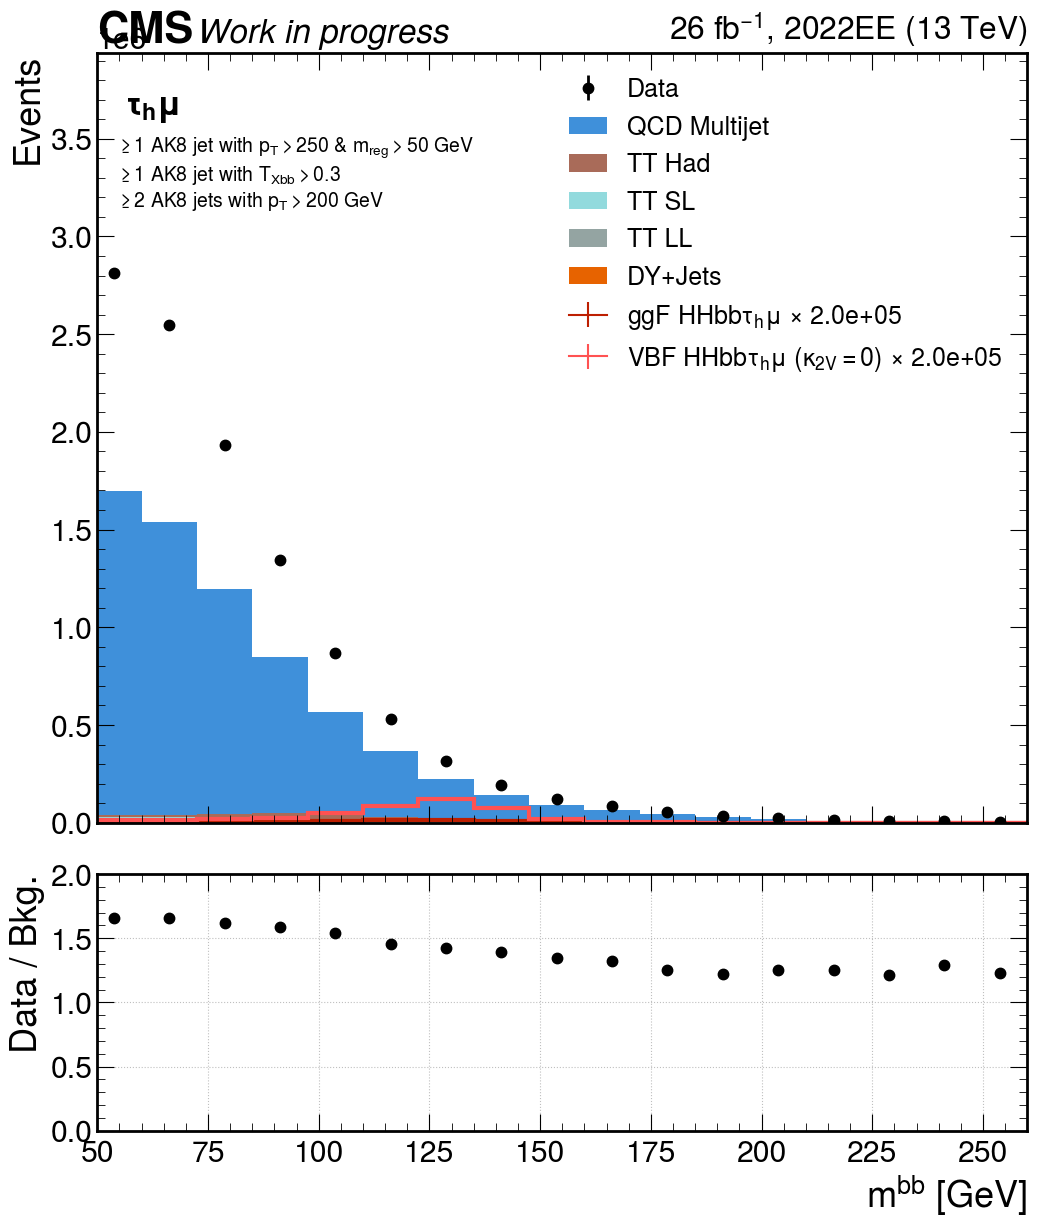

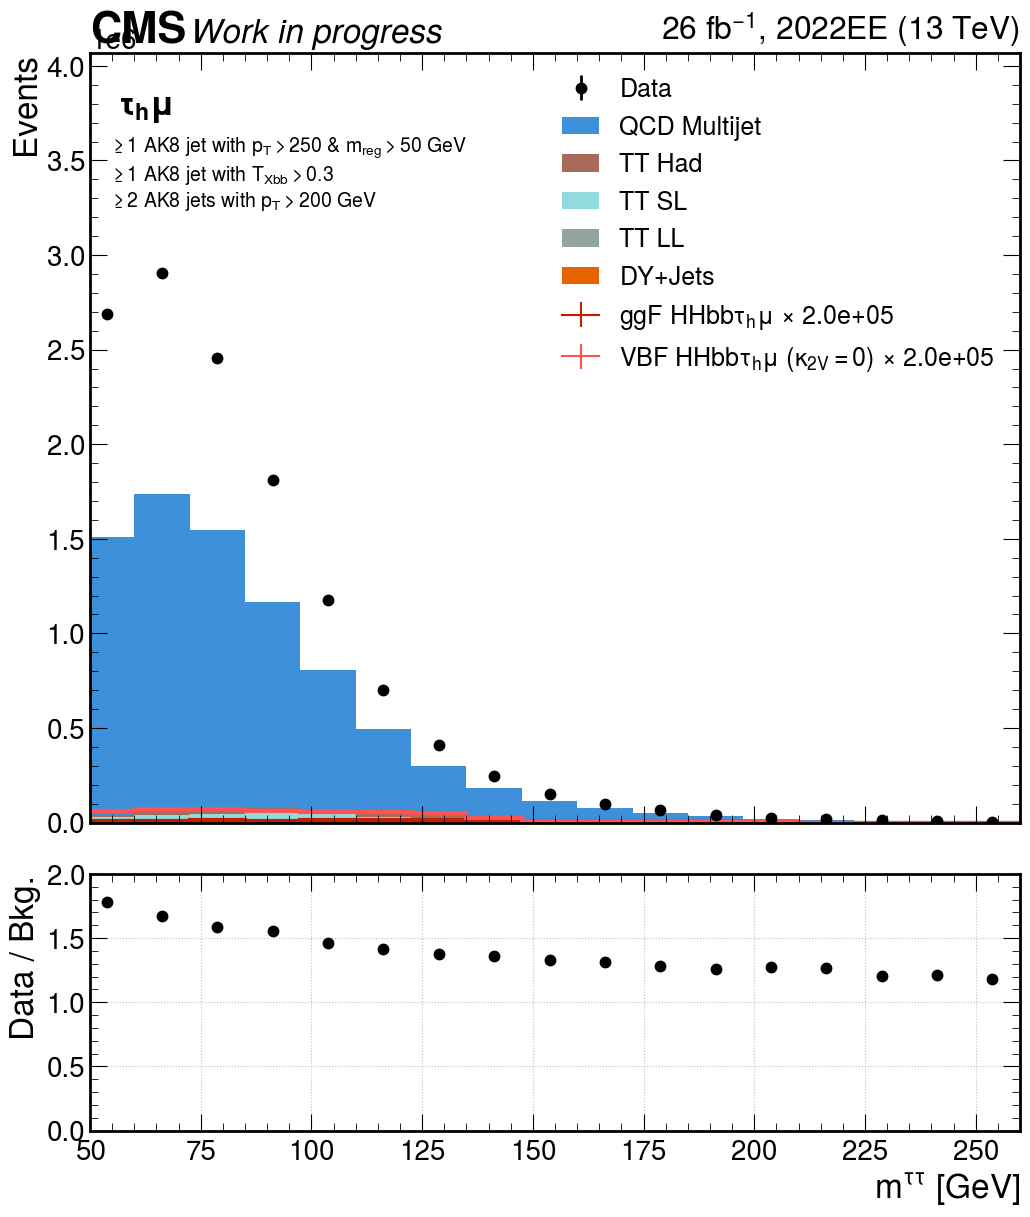

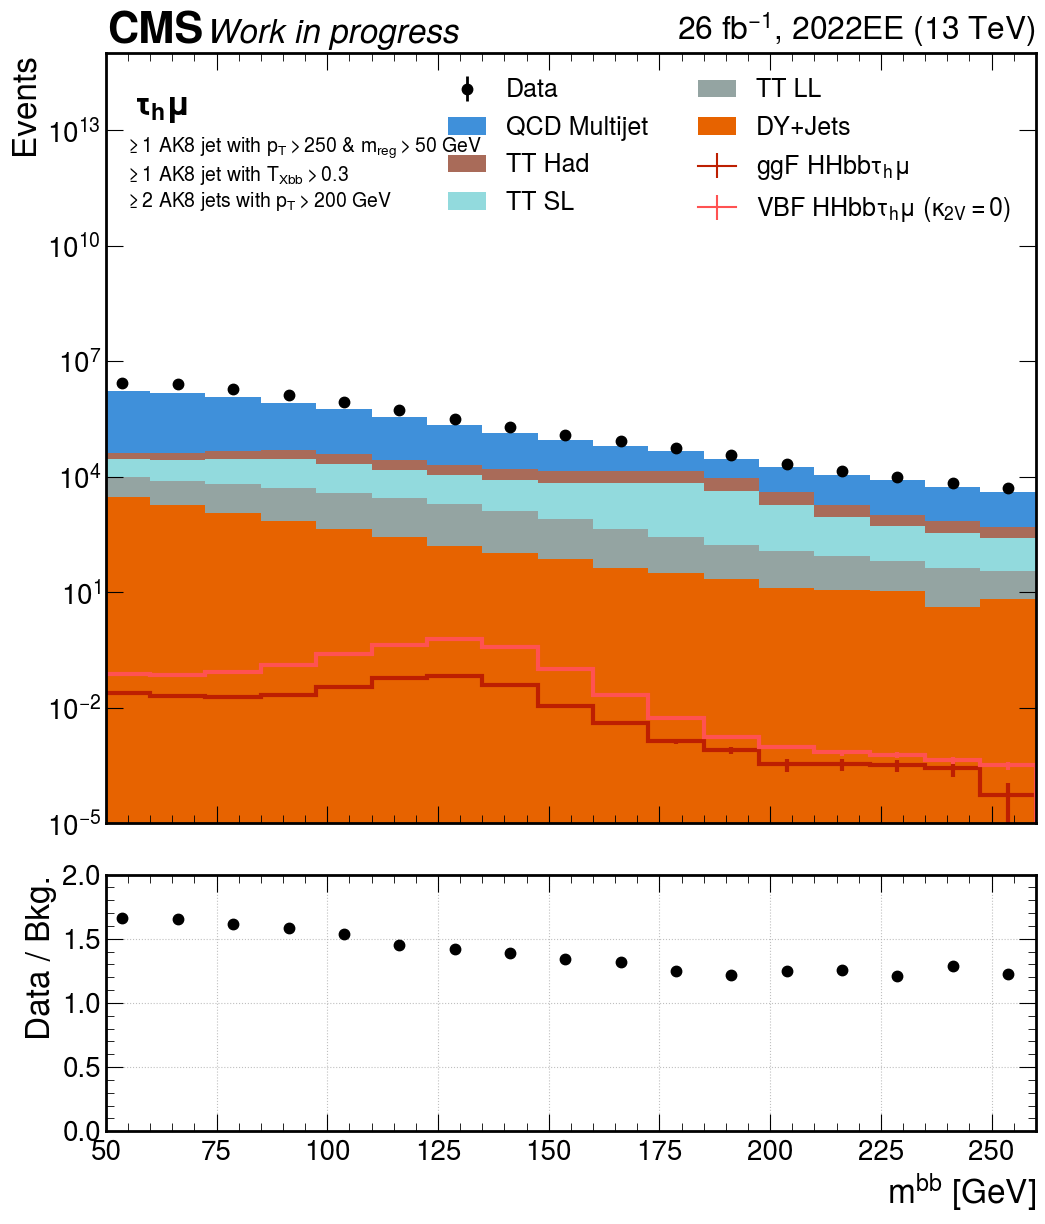

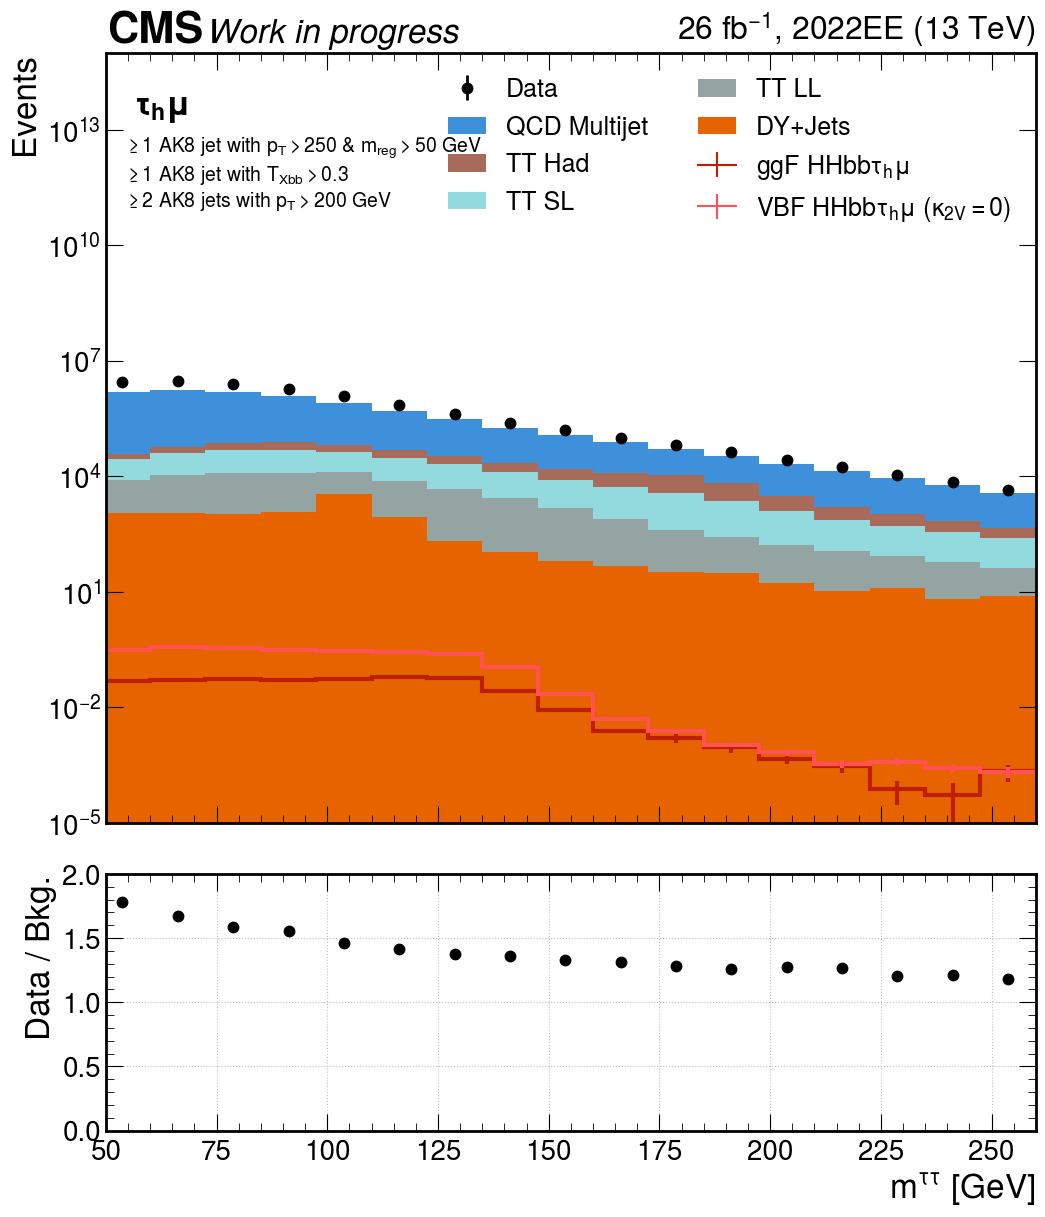

In [13]:
from PyPDF2 import PdfMerger
from boostedhh.utils import Sample, ShapeVar
import pickle
from bbtautau.postprocessing import plotting as bbtautauplt


hists = {}
sig_scale_dict = {sig_key: 2e5 for sig_key in sigs}
selection = None
log = "both"
cutstr: str = "",

mass_plot_vars = (
    [
        ShapeVar(var=f"{jet}FatJetMass", label=rf"$m^{{{jlabel}}}$ [GeV]", bins=[20, 10, 260])
        for jet, jlabel in [("bb", "bb"), ("tt", r"\tau\tau")]
    ]
)

for shape_var in mass_plot_vars:
    if shape_var.var not in hists:
        hists[shape_var.var] = putils.singleVarHist(
            events_dict,
            shape_var,
            CHANNEL,
            bbtt_masks=bbtt_masks,
            weight_key="finalWeight",
            selection=selection,
        )

print(hists)

ylim = None

with (plot_dir / "hists.pkl").open("wb") as f:
    pickle.dump(hists, f)

do_log = [True, False] if log == "both" else [log]

for log, logstr in [(False, ""), (True, "_log")]:
    if log not in do_log:
        continue

    merger_control_plots = PdfMerger()

    for shape_var in mass_plot_vars:
        pylim = np.max(hists[shape_var.var].values()) * 1.4 if ylim is None else ylim

        name = f"{plot_dir}/{cutstr}{shape_var.var}{logstr}.pdf"

        bbtautauplt.ratioHistPlot(
                hists[shape_var.var],
                year,
                CHANNEL,
                list(sigs.keys()),
                list(bgs.keys()),
                cutlabel=cutlabel,
                name=name,
                title=None,
                sig_scale_dict=sig_scale_dict if not log else None,
                plot_significance=False,
                significance_dir=shape_var.significance_dir,
                show=True,
                xlowlim=50,
                xlim=260,
                log=log,
                ylim=pylim if not log else 1e15,
                plot_ratio=True,
                cmslabel="Work in progress",
                leg_args={"fontsize": 18},
            )

In [14]:
mass_dict = {}

for jet in ["bb", "tt"]:
    print(jet)
    mass_dict[jet] = {}
    for sample_key in [*sigs.keys(), *bgs.keys()]:
        print("\t"+sample_key)
        mass_dict[jet][sample_key] = {}

        for i, mass_key in enumerate(
            ["ak8FatJetMass", "ak8FatJetMsd", "ak8FatJetParTmassResApplied", "ak8FatJetParTmassVisApplied", "ak8FatJetPNetmassLegacy"]
        ):
            print("\t\t\t" + mass_key)

            mass = get_jet_vals(events_dict[sample_key][mass_key], bbtt_masks[sample_key][jet])
            weight = events_dict[sample_key]["finalWeight"]

    
            mass_dict[jet][sample_key][mass_key] = {
                "mass": mass,
                "weight": weight,
            }

bb
	bbtthm
			ak8FatJetMass


NameError: name 'get_jet_vals' is not defined